#### AAVSO Lightcurve for AG DRa
https://www.aavso.org/LCGv2/index.htm?DateFormat=Calendar&RequestedBands=V,R,I,B&view=api.delim&ident=agdra&fromjd=2457894&tojd=2458504.578&delimiter=@@@

#### Link to ARAS page 
http://www.astrosurf.com/aras/Aras_DataBase/Symbiotics/AGDra.htm

_Importing modules and stuff_

In [1]:
import astropy.utils.data as aua
import astropy.io.fits as aif
import astropy.constants as const
import matplotlib.pyplot as pl
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
import scipy as sp
import os
import pickle

_Define Object ARAS Website link and requirements for spectra_

In [2]:
rootsite = "http://www.astrosurf.com/aras/Aras_DataBase/Symbiotics/"
topic = "AGDra.htm"
minimal_resolution = 8000
minimal_wavelength_range = 2000

_Scraping the page of the object of interest, looking for .fit files_

In [3]:
rootsite = "http://www.astrosurf.com/aras/Aras_DataBase/Symbiotics/"
topic = "AGDra.htm"
site = "{}/{}".format(rootsite, topic)
soup = BeautifulSoup(urlopen(site), "html")
spectra_list = []
for link in soup.findAll('a'):
    linkhref = link.get('href')
    if ".fit" in linkhref:
        if "http" not in linkhref:
            spectra_list.append(rootsite+linkhref)
        else:
            spectra_list.append(linkhref)

_Download each fit and save it into pickle file if resolution and wavelength range requirements are respected. If a pickle dump file is already existing in the current directory, nothing will be downloaded and the data will be loaded in memory_

In [4]:
pickle_file = 'ag_dra.dump.pckl'
if not os.path.isfile(pickle_file):
    data = []
    for link in spectra_list:
        try:
            hdul = aif.open(aua.download_file(link))
            hdr = hdul[0].header
            spectrum = hdul[0].data
        except:
            print("broken link? {}".format(link))
            continue
        # calculate resolution of spectrum
        resolution = hdr['CRVAL1']/hdr['CDELT1']
        if resolution >= minimal_resolution:
            # derivate wavelength array            
            wavelengths = hdr['CDELT1']*np.arange(hdr['NAXIS1']) + hdr['CRVAL1']
            wavelength_range = wavelengths[-1] - wavelengths[0]
            if wavelength_range >= minimal_wavelength_range:
                data.append({"w" : wavelengths, "f" : spectrum, 
                             "do" : hdr['DATE-OBS'], "hdr" : hdr})
                print("Saving {}".format(link.split("/")[-1]))
                
    print("Saving {} spectra in total".format(len(data)))
    with open(pickle_file, 'wb') as output:
        pickle.dump(data, output)
elif os.path.isfile(pickle_file):
    data = []
    print("Pickle dump {} found".format(pickle_file))
    data = pickle.load(open(pickle_file, "rb"))
    print("Loaded {} spectra".format(len(data)))
else:
    print("eh what do you want??")

Pickle dump ag_dra.dump.pckl found
Loaded 134 spectra


_Some helpful methods_

**calculate_velocity**: returns the velocity array (in km/s) with respect to a specific wavlength _wl_

**linelabel**: simple text output with a specific wavelength _wl_

**plot_line**: plots the normalised flux (normalised with respect to the maximum flux of the dataset) from a dataset (specified with the index _i_ with the respect to the data structure) against the velocity array, centered on a specific wavelength _wl_; _dobs_ and _labwl_ specificy if the label of the plotted curve will show the data of the observation and/or the wavelength; _alpha_ (0,1) specifies the transparency of the curve; _factor_ rescales the curve.

In [ ]:
def calculate_velocity(wave, wavelength):
    return 1e-3*const.c*(wave - wavelength)/wavelength

def linelabel(wl):
    return "{:.1f} $\AA$".format(wl)

def plot_line(i, wl, dobs=False, labwl=False, alpha=1, factor=1):
    vel = calculate_velocity(data[i]["w"], wl)
    if dobs:
        label_for_line = "#{} - {}".format(i, data[i]["do"])
    if labwl:
        label_for_line = "#{} - {}".format(i, linelabel(wl))
    if labwl and dobs:
        label_for_line = "#{} - {} - {}".format(i, linelabel(wl), data[i]["do"])
    flux = data[i]["f"]/max(data[i]["f"])
    pl.plot(vel, flux*factor, label = label_for_line, alpha=alpha)

#### Plot same line from different observations

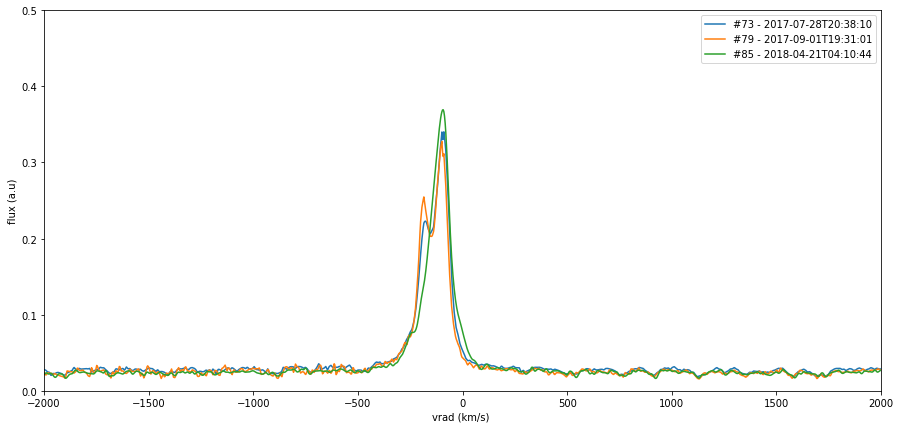

In [ ]:
fig = pl.figure(1, figsize = (15, 7))

w_hbeta = 4861.
plot_line(73, w_hbeta, dobs=True)
plot_line(79, w_hbeta, dobs=True)
plot_line(85, w_hbeta, dobs=True)

pl.xlim(-2000, 2000)
pl.xlabel('vrad (km/s) ')
pl.ylim(0, 0.5)
pl.ylabel('flux (a.u)')
pl.legend()

#### Plot several lines from same observations

In [ ]:
fig = pl.figure(2, figsize = (15, 7))

i_obs = 67
plot_line(i_obs, 4861., labwl=True)
plot_line(i_obs, 5015., labwl=True)
plot_line(i_obs, 5875, labwl=True)

pl.xlim(-2000, 2000)
pl.xlabel('vrad (km/s) ')
pl.ylim(0, 0.5)
pl.ylabel('flux (a.u)')
pl.legend()

In [ ]:
# Convert the notebook to script
!jupyter nbconvert --to script ag_dra.ipynb
# Calculate requirements
!pipreqs . --force